# Train the networks for modulation recognition

## Preambule

In [1]:
# Authors: Helion du Mas des Bourboux <helion.dumasdesbourboux'at'thalesgroup.com>
#         Thomas Courtat <thomas.courtat'at'thalesgroup.com>

# MIT License

# Copyright (c) 2021 Thales Six GTS France

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

### Imports

In [2]:
import sys
from os import mkdir
from os.path import exists as path_exists
from os.path import join
import time

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42

import tensorflow.keras
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.python.client import device_lib
from tensorflow import convert_to_tensor
from tensorflow.keras.backend import clear_session

print(f'Tensorflow version {tensorflow.__version__}')
print(f'Available devices:\n{[x.name for x in device_lib.list_local_devices()]}')


from pythagore_modreco.data import read_augmod, read_RML2016, read_RML2018
from pythagore_modreco.utils import TimeHistory,split_dataset
from pythagore_modreco import neural_nets_keras


np.random.seed(2015)

Tensorflow version 2.4.0
Available devices:
['/device:CPU:0', '/device:GPU:0', '/device:GPU:1', '/device:GPU:2']


### General settings

In [3]:
# Please specify the folder where your dataset(s) is/are
data_path = <your data path>

# Please specify a folder to log information during model training 
log_path = <your log path>

if not path_exists(log_path):
    mkdir(log_path)

#### Dataset settings

In [4]:
# Please chose a dataset name from:
# AugMod
# RadioML2016.04c
# RadioML2016.10a
# RadioML2016.10b
# RadioML2018.01a
dataset_name = "AugMod"

# Please choose signal duration in seconds. 
# Beware, that duration should be less or equal to the chosen dataset signal lengths
# Set to None if you want to take as much as there is in the dataset
signal_duration = 128

# Please choose a cut in SNR
# The resulting dataset will consit in all data>=snr_cut
# set to None if no cut
snr_cut = 0.

#### Trainning settings

In [5]:
nb_epoch = 200
batch_size = 512

## Data loading and preparation

Load the selected dataset ; 

This cell outputs: 
- signals : a numpy array containing signal data 
- class_onehot : a numpy array containing one hot encoded labels associated to data 
- snrs: an array associating snr to each signal 
- class_list: a list of strings associating the modulation / signal kind name to the indexes of labels

In [6]:
if dataset_name == "AugMod":
    
    fName = join(data_path,'augmod.hdf5')
    data_dict = read_augmod(fName)
    
    signals  = data_dict['signals']
    class_idx = data_dict['modulations']
    snrs = data_dict['snr']
    
    class_onehot = to_categorical(class_idx)
    class_list = data_dict['classes']
    
elif dataset_name == "RadioML2016.04c":

    fName = join(data_path,'2016.04C.multisnr.pkl')
    
    signals, class_idx, snrs, class_list = read_RML2016(fName)
    class_onehot = to_categorical(class_idx)
    
elif dataset_name == "RadioML2016.10a":

    fName = join(data_path,'RML2016.10a_dict.pkl')
    
    signals, class_idx, snrs,class_list = read_RML2016(fName)
    class_onehot = to_categorical(class_idx)
    
elif dataset_name == "RadioML2016.10b":

    fName = join(data_path,'RML2016.10b.dat')
    
    signals, class_idx, snrs,class_list = read_RML2016(fName)
    class_onehot = to_categorical(class_idx)
    
elif dataset_name == "RadioML2018.01a":

    fName = join(data_path,'GOLD_XYZ_OSC.0001_1024.hdf5')
    
    signals, class_onehot, snrs ,class_list = read_RML2018(fName)
    #snrs = snrs.reshape(-1)
    class_idx = np.argmax(class_onehot,axis=-1)
else: 
    print('Data not found')

In [7]:
snrs_list = sorted( list( set( snrs ) ) )
print(f'{dataset_name} loaded, {signals.shape[0]} signal with shape {signals.shape[1:]}' )
print(f'List of signal SNR: {snrs_list}')
print(f'List of modulations under consideration: {class_list}')

AugMod loaded, 174720 signal with shape (2, 1024)
List of signal SNR: [0.0, 10.0, 20.0, 30.0, 40.0]
List of modulations under consideration: ['BPSK', 'PSK8', 'QAM16', 'QAM32', 'QAM64', 'QAM8', 'QPSK']


Transposes the data so the real/imag axis is the last as expected by deep learning models

In [8]:
print(f'Initial data shape: {signals.shape}')
signals = signals.transpose((0,2,1))
print(f'Transposed data shape: {signals.shape}' )

Initial data shape: (174720, 2, 1024)
Transposed data shape: (174720, 1024, 2)


Trunk signal to `signal_duration`samples. 

In [9]:
if not signal_duration is None:
    print(f'Initial data shape: {signals.shape}')
    signals = signals[:,:signal_duration,:]
    print(f'Trunked data shape: {signals.shape}' )

Initial data shape: (174720, 1024, 2)
Trunked data shape: (174720, 128, 2)


Filters signal by snr if requested above

In [10]:
if not snr_cut is None:
    print(f'Initial data shape: {signals.shape}')
    w = snrs>=snr_cut
    signals = signals[w]
    class_idx = class_idx[w]
    snrs = snrs[w]
    class_onehot = class_onehot[w]
    print(f'New data shape: {signals.shape}' )

Initial data shape: (174720, 128, 2)
New data shape: (174720, 128, 2)


Normalize the power of each signal

In [11]:
### Normalize the power of each signal
norm = np.sqrt(np.mean(signals**2,axis=(1,2),keepdims=True))
signals/=norm

Split dataset into train and test sets. Also shuffles data.

In [12]:
X_train, y_train, train_idx ,_,_,_, X_test,y_test,test_idx= split_dataset(signals, 
    class_onehot, 
    p_train=0.5,p_test=0.5)

SNR_train = snrs[train_idx]
SNR_test = snrs[test_idx]

print(f'Train dataset shape: {X_train.shape}')
print(f'Test dataset shape: {X_test.shape} ')

Train dataset shape: (87360, 128, 2)
Test dataset shape: (87360, 128, 2) 


In [13]:
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test  shape: {X_test.shape}, y_test  shape: {y_test.shape}')

input_shp = list(X_train.shape[1:])
output_shp = y_train.shape[1]

print(f'Network input shape in variable input-shp: {input_shp}')
print(f'Network output shape in variable input-shp: {output_shp}')

X_train shape: (87360, 128, 2), y_train shape: (87360, 7)
X_test  shape: (87360, 128, 2), y_test  shape: (87360, 7)
Network input shape in variable input-shp: [128, 2]
Network output shape in variable input-shp: 7


In [14]:
X_train = convert_to_tensor(X_train)
y_train = convert_to_tensor(y_train)
X_test = convert_to_tensor(X_test)
y_test = convert_to_tensor(y_test)

## Deep learning model training 

Define a function to instanciate and train a deep learning model

In [15]:
def train_model(model,name_network): 
    
    clear_session()
    time_callback = TimeHistory()

    history = model.fit(X_train, y_train,
                        epochs=nb_epoch, batch_size=batch_size,
                        validation_data =( X_test , y_test ), 
                        verbose=1,
                        callbacks=[time_callback])

    model.save(join(log_path,'model-{}-{}-trained{}.h5'.format(dataset_name,name_network,signal_duration)))

    data = np.array(list(zip(history.epoch, history.history['val_accuracy'], history.history['accuracy'])))
    np.savetxt(join(log_path,'history-{}-{}-trained{}.txt'.format(dataset_name,name_network,signal_duration)),data)

    data = np.array(list(zip(history.epoch, time_callback.times)))
    np.savetxt(join(log_path,'history_time-{}-{}-trained{}.txt'.format(dataset_name,name_network,signal_duration)),data)
    
    clear_session()

### LModCNN (ours)

Generate LModCNN architecture as defined in Courtat and du Mas des Bourboux, <i>A light neural network for modulation detection under impairments</i>, ISNCC 2021


In [16]:
name_network = "LModCNN"

dynamic_input_shp = input_shp.copy()
dynamic_input_shp[0] = None

model = getattr(neural_nets_keras,'get_{}'.format(name_network))(dynamic_input_shp,output_shp)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 8)           120       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          912       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          3616      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          14400     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [17]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_model(model, name_network)

Epoch 1/200
171/171 [==============================] - 41s 128ms/step - loss: 1.8801 - accuracy: 0.1880 - val_loss: 1.6379 - val_accuracy: 0.2864
Epoch 2/200
171/171 [==============================] - 4s 22ms/step - loss: 1.6230 - accuracy: 0.2912 - val_loss: 1.5900 - val_accuracy: 0.2982
Epoch 3/200
171/171 [==============================] - 4s 23ms/step - loss: 1.5639 - accuracy: 0.3150 - val_loss: 1.5262 - val_accuracy: 0.3335
Epoch 4/200
171/171 [==============================] - 3s 18ms/step - loss: 1.5294 - accuracy: 0.3359 - val_loss: 1.4817 - val_accuracy: 0.3689
Epoch 5/200
171/171 [==============================] - 4s 24ms/step - loss: 1.4754 - accuracy: 0.3697 - val_loss: 1.4533 - val_accuracy: 0.3769
Epoch 6/200
171/171 [==============================] - 4s 22ms/step - loss: 1.4198 - accuracy: 0.4002 - val_loss: 1.3595 - val_accuracy: 0.4269
Epoch 7/200
171/171 [==============================] - 4s 21ms/step - loss: 1.3562 - accuracy: 0.4252 - val_loss: 1.2977 - val_accurac

171/171 [==============================] - 4s 22ms/step - loss: 0.7072 - accuracy: 0.6945 - val_loss: 0.7164 - val_accuracy: 0.6910
Epoch 114/200
171/171 [==============================] - 4s 23ms/step - loss: 0.7021 - accuracy: 0.6974 - val_loss: 0.7165 - val_accuracy: 0.6890
Epoch 115/200
171/171 [==============================] - 4s 21ms/step - loss: 0.7083 - accuracy: 0.6965 - val_loss: 0.7061 - val_accuracy: 0.6938
Epoch 116/200
171/171 [==============================] - 4s 22ms/step - loss: 0.7068 - accuracy: 0.6964 - val_loss: 0.7082 - val_accuracy: 0.6951
Epoch 117/200
171/171 [==============================] - 4s 21ms/step - loss: 0.6978 - accuracy: 0.7000 - val_loss: 0.7102 - val_accuracy: 0.6943
Epoch 118/200
171/171 [==============================] - 4s 23ms/step - loss: 0.6939 - accuracy: 0.7003 - val_loss: 0.7059 - val_accuracy: 0.6985
Epoch 119/200
171/171 [==============================] - 4s 22ms/step - loss: 0.6953 - accuracy: 0.7012 - val_loss: 0.7115 - val_accuracy:

### LModCNNResNet Relu (ours)

Generate LModCNN with residual connexion architecture as defined in Courtat and du Mas des Bourboux, <i>A light neural network for modulation detection under impairments</i>, ISNCC 2021

In [18]:
name_network = "LModCNNResNetRelu"

dynamic_input_shp = input_shp.copy()
dynamic_input_shp[0] = None

model = getattr(neural_nets_keras,'get_{}'.format(name_network))(dynamic_input_shp,output_shp)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 8)      24          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 8)      456         conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 8)      456         conv1d_1[0][0]                   
______________________________________________________________________________________________

In [19]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_model(model, name_network)

Epoch 1/200
171/171 [==============================] - 93s 302ms/step - loss: 1.8576 - accuracy: 0.1951 - val_loss: 1.5099 - val_accuracy: 0.3558
Epoch 2/200
171/171 [==============================] - 8s 46ms/step - loss: 1.3931 - accuracy: 0.3754 - val_loss: 1.1735 - val_accuracy: 0.4575
Epoch 3/200
171/171 [==============================] - 8s 44ms/step - loss: 1.1861 - accuracy: 0.4537 - val_loss: 1.0960 - val_accuracy: 0.5004
Epoch 4/200
171/171 [==============================] - 8s 46ms/step - loss: 1.1003 - accuracy: 0.4984 - val_loss: 1.1030 - val_accuracy: 0.4880
Epoch 5/200
171/171 [==============================] - 7s 42ms/step - loss: 1.0640 - accuracy: 0.5141 - val_loss: 1.0521 - val_accuracy: 0.5219
Epoch 6/200
171/171 [==============================] - 8s 46ms/step - loss: 1.0396 - accuracy: 0.5232 - val_loss: 1.0049 - val_accuracy: 0.5358
Epoch 7/200
171/171 [==============================] - 8s 45ms/step - loss: 1.0230 - accuracy: 0.5294 - val_loss: 1.0806 - val_accurac

171/171 [==============================] - 8s 47ms/step - loss: 0.4660 - accuracy: 0.7967 - val_loss: 0.6609 - val_accuracy: 0.7435
Epoch 114/200
171/171 [==============================] - 8s 45ms/step - loss: 0.4683 - accuracy: 0.7933 - val_loss: 0.6675 - val_accuracy: 0.7396
Epoch 115/200
171/171 [==============================] - 8s 45ms/step - loss: 0.4764 - accuracy: 0.7924 - val_loss: 0.6685 - val_accuracy: 0.7444
Epoch 116/200
171/171 [==============================] - 8s 46ms/step - loss: 0.4648 - accuracy: 0.7962 - val_loss: 0.6775 - val_accuracy: 0.7437
Epoch 117/200
171/171 [==============================] - 8s 45ms/step - loss: 0.4695 - accuracy: 0.7914 - val_loss: 0.6833 - val_accuracy: 0.7416
Epoch 118/200
171/171 [==============================] - 7s 41ms/step - loss: 0.4748 - accuracy: 0.7938 - val_loss: 0.6742 - val_accuracy: 0.7437
Epoch 119/200
171/171 [==============================] - 6s 33ms/step - loss: 0.4628 - accuracy: 0.7961 - val_loss: 0.7109 - val_accuracy:

### RMLConvNet

Generate RMLConvNet as defined in O'Shea et Al., <i>Convolutional radio modulation recognition networks</i>, 2016
The implementation is an adaptation of
https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb


In [20]:
name_network = "RMLConvNet"

model = getattr(neural_nets_keras,'get_{}'.format(name_network))(input_shp,output_shp)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 128, 2, 1)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 132, 2, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 2, 256)       1024      
_________________________________________________________________
dropout (Dropout)            (None, 130, 2, 256)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 134, 2, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 132, 1, 80)        122960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 132, 1, 80)        0

In [21]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_model(model, name_network)

Epoch 1/200
171/171 [==============================] - 26s 97ms/step - loss: 1.8482 - accuracy: 0.1901 - val_loss: 1.5959 - val_accuracy: 0.2836
Epoch 2/200
171/171 [==============================] - 7s 42ms/step - loss: 1.5924 - accuracy: 0.2946 - val_loss: 1.3568 - val_accuracy: 0.4201
Epoch 3/200
171/171 [==============================] - 7s 41ms/step - loss: 1.3439 - accuracy: 0.4136 - val_loss: 1.1438 - val_accuracy: 0.4934
Epoch 4/200
171/171 [==============================] - 7s 41ms/step - loss: 1.1853 - accuracy: 0.4716 - val_loss: 1.0729 - val_accuracy: 0.5026
Epoch 5/200
171/171 [==============================] - 7s 42ms/step - loss: 1.1094 - accuracy: 0.5019 - val_loss: 1.0120 - val_accuracy: 0.5413
Epoch 6/200
171/171 [==============================] - 7s 42ms/step - loss: 1.0513 - accuracy: 0.5254 - val_loss: 1.0013 - val_accuracy: 0.5367
Epoch 7/200
171/171 [==============================] - 7s 43ms/step - loss: 1.0187 - accuracy: 0.5421 - val_loss: 0.9492 - val_accuracy

171/171 [==============================] - 7s 43ms/step - loss: 0.5381 - accuracy: 0.7868 - val_loss: 0.8918 - val_accuracy: 0.6071
Epoch 114/200
171/171 [==============================] - 7s 42ms/step - loss: 0.5312 - accuracy: 0.7894 - val_loss: 0.8940 - val_accuracy: 0.6050
Epoch 115/200
171/171 [==============================] - 7s 42ms/step - loss: 0.5328 - accuracy: 0.7910 - val_loss: 0.8884 - val_accuracy: 0.6040
Epoch 116/200
171/171 [==============================] - 7s 41ms/step - loss: 0.5323 - accuracy: 0.7885 - val_loss: 0.8934 - val_accuracy: 0.6024
Epoch 117/200
171/171 [==============================] - 7s 41ms/step - loss: 0.5286 - accuracy: 0.7902 - val_loss: 0.8855 - val_accuracy: 0.6075
Epoch 118/200
171/171 [==============================] - 7s 44ms/step - loss: 0.5259 - accuracy: 0.7923 - val_loss: 0.9032 - val_accuracy: 0.5997
Epoch 119/200
171/171 [==============================] - 7s 41ms/step - loss: 0.5267 - accuracy: 0.7930 - val_loss: 0.8926 - val_accuracy:

### RMLCNNVGG

Generate RML CNN/VGG  as defined in O'Shea et Al., <i>Over-the-Air Deep Learning Based Radio Signal Classification</i>,  2018. The implementation is an adaptation of https://github.com/leena201818/radioml/blob/master/rmlmodels/VGGLikeModel.py


In [22]:
name_network = "RMLCNNVGG"

model = getattr(neural_nets_keras,'get_{}'.format(name_network))(input_shp,output_shp)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 64)           960       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 64)            28736     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 64)            28736     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16, 64)            2

In [23]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_model(model, name_network)

Epoch 1/200
171/171 [==============================] - 86s 264ms/step - loss: 1.9318 - accuracy: 0.1566 - val_loss: 1.6265 - val_accuracy: 0.2654
Epoch 2/200
171/171 [==============================] - 3s 20ms/step - loss: 1.6246 - accuracy: 0.2700 - val_loss: 1.5939 - val_accuracy: 0.2853
Epoch 3/200
171/171 [==============================] - 3s 20ms/step - loss: 1.5832 - accuracy: 0.2843 - val_loss: 1.5587 - val_accuracy: 0.2966
Epoch 4/200
171/171 [==============================] - 3s 20ms/step - loss: 1.5255 - accuracy: 0.3180 - val_loss: 1.1931 - val_accuracy: 0.4331
Epoch 5/200
171/171 [==============================] - 3s 20ms/step - loss: 1.1855 - accuracy: 0.4330 - val_loss: 1.1008 - val_accuracy: 0.4587
Epoch 6/200
171/171 [==============================] - 3s 19ms/step - loss: 1.0911 - accuracy: 0.4610 - val_loss: 1.0833 - val_accuracy: 0.4625
Epoch 7/200
171/171 [==============================] - 3s 20ms/step - loss: 1.0525 - accuracy: 0.4693 - val_loss: 1.0641 - val_accurac

171/171 [==============================] - 4s 21ms/step - loss: 0.1506 - accuracy: 0.9417 - val_loss: 2.7317 - val_accuracy: 0.5550
Epoch 114/200
171/171 [==============================] - 3s 20ms/step - loss: 0.1626 - accuracy: 0.9396 - val_loss: 2.8667 - val_accuracy: 0.5588
Epoch 115/200
171/171 [==============================] - 4s 21ms/step - loss: 0.1437 - accuracy: 0.9478 - val_loss: 2.7849 - val_accuracy: 0.5591
Epoch 116/200
171/171 [==============================] - 4s 22ms/step - loss: 0.1503 - accuracy: 0.9437 - val_loss: 2.8135 - val_accuracy: 0.5577
Epoch 117/200
171/171 [==============================] - 4s 21ms/step - loss: 0.1389 - accuracy: 0.9482 - val_loss: 2.9121 - val_accuracy: 0.5558
Epoch 118/200
171/171 [==============================] - 4s 21ms/step - loss: 0.1495 - accuracy: 0.9436 - val_loss: 2.9163 - val_accuracy: 0.5568
Epoch 119/200
171/171 [==============================] - 4s 21ms/step - loss: 0.1411 - accuracy: 0.9476 - val_loss: 2.9280 - val_accuracy:

### RMLResNet
Generate RML Residual Network  as defined in O'Shea et Al., <i> Over-the-Air Deep Learning Based Radio Signal Classification</i>,  2018. 
The implementation is an adaptation of https://github.com/liuzhejun/ResNet-for-Radio-Recognition/blob/master/ResNet_Model.ipynb


In [24]:
name_network = "RMLResNet"

model = getattr(neural_nets_keras,'get_{}'.format(name_network))(input_shp,output_shp)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 128, 2, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
ReStk1_conv1 (Conv2D)           (None, 128, 2, 32)   64          reshape[0][0]                    
__________________________________________________________________________________________________
ReStk1_conv2 (Conv2D)           (None, 128, 2, 32)   6176        ReStk1_conv1[0][0]               
______________________________________________________________________________________________

In [25]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_model(model, name_network)

Epoch 1/200
171/171 [==============================] - 183s 549ms/step - loss: 2.1894 - accuracy: 0.1565 - val_loss: 1.6906 - val_accuracy: 0.2629
Epoch 2/200
171/171 [==============================] - 7s 40ms/step - loss: 1.6452 - accuracy: 0.2821 - val_loss: 1.6101 - val_accuracy: 0.3174
Epoch 3/200
171/171 [==============================] - 7s 43ms/step - loss: 1.4873 - accuracy: 0.3566 - val_loss: 1.1553 - val_accuracy: 0.4655
Epoch 4/200
171/171 [==============================] - 7s 40ms/step - loss: 1.1475 - accuracy: 0.4625 - val_loss: 1.2031 - val_accuracy: 0.4817
Epoch 5/200
171/171 [==============================] - 7s 42ms/step - loss: 1.0980 - accuracy: 0.4856 - val_loss: 1.1522 - val_accuracy: 0.5037
Epoch 6/200
171/171 [==============================] - 7s 44ms/step - loss: 1.0051 - accuracy: 0.5254 - val_loss: 1.0528 - val_accuracy: 0.5221
Epoch 7/200
171/171 [==============================] - 7s 43ms/step - loss: 0.9841 - accuracy: 0.5305 - val_loss: 1.0153 - val_accura

171/171 [==============================] - 8s 45ms/step - loss: 0.4738 - accuracy: 0.8001 - val_loss: 1.5417 - val_accuracy: 0.6670
Epoch 114/200
171/171 [==============================] - 8s 46ms/step - loss: 0.4529 - accuracy: 0.8074 - val_loss: 1.7251 - val_accuracy: 0.6636
Epoch 115/200
171/171 [==============================] - 7s 44ms/step - loss: 0.4569 - accuracy: 0.8069 - val_loss: 1.6776 - val_accuracy: 0.6685
Epoch 116/200
171/171 [==============================] - 7s 41ms/step - loss: 0.4624 - accuracy: 0.8048 - val_loss: 1.7361 - val_accuracy: 0.6698
Epoch 117/200
171/171 [==============================] - 7s 41ms/step - loss: 0.4579 - accuracy: 0.8077 - val_loss: 1.7970 - val_accuracy: 0.6640
Epoch 118/200
171/171 [==============================] - 7s 40ms/step - loss: 0.4698 - accuracy: 0.8018 - val_loss: 1.4892 - val_accuracy: 0.6665
Epoch 119/200
171/171 [==============================] - 7s 42ms/step - loss: 0.4551 - accuracy: 0.8067 - val_loss: 1.7375 - val_accuracy:

## Results and comparisons

In [26]:
from_name_to_legend = {
    'RMLConvNet':'RML-ConvNet',
    'RMLCNNVGG':'RML-CNN/VGG',
    'RMLResNet':'RML-ResNet',
    'LModCNN':'Mod-LCNN (ours)',
    'LModCNNResNetRelu':'Mod-LRCNN (ours)',
}

networks_to_plot = ['RMLConvNet','RMLCNNVGG','RMLResNet','LModCNN','LModCNNResNetRelu' ]

### Plot training trajectories

Plots the evolution of error through learning epochs both for train and test dataset.

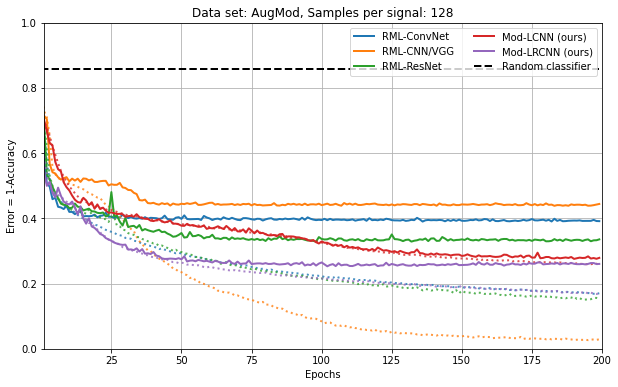

In [27]:
plt.figure(figsize=(10,6))

for name_network in networks_to_plot:

    data = np.loadtxt(join(log_path,'history-{}-{}-trained{}.txt'.format(dataset_name,name_network,signal_duration)))

    p = plt.plot(data[:,0], 1.-data[:,1],
        label=from_name_to_legend[name_network],linewidth=2)
    plt.plot(data[:,0], 1.-data[:,2],':',
        linewidth=2,color=p[0].get_color(),alpha=0.8)

plt.plot(data[:,0] ,1.-1./output_shp*np.ones_like(data[:,0]),
    '--',label='Random classifier',linewidth=2,color='black')

plt.legend(ncol=2,loc=1)
plt.grid()
plt.ylabel('Error = 1-Accuracy')
plt.xlabel('Epochs')
plt.title(f'Data set: {dataset_name}, Samples per signal: {signal_duration}')
plt.ylim([0.,1.])
plt.xlim([1,nb_epoch])
plt.savefig(join(log_path,'network_comparison_{}-trained{}.pdf'.format(dataset_name,signal_duration)))
plt.show()

Solid curves are for the test set and dotted curves for the training set

Lower is better

### Print final performances

Displays test accuracy for different algorithmes and train/test computation time

In [28]:
f = open(join(log_path,'perfs-{}-{}-trained{}.txt'.format(dataset_name,'all',signal_duration)), 'w')

f.write(f'#Performance evaluations, Data set: {dataset_name}, Samples per signal: {signal_duration}\n')
    
f.write(f"#{'':20s}{'Loss':15s}{'Accuracy':15s}{'Training time':20s}{'Inference time':20s}{'# Parameters':15s}\n")
f.write(f"#{'':20s}{'':15s}{'':15s}{'(s/epoch)':20s}{'(ms/signal)':20s}\n")
f.write(f"#{'-'*110}\n")

for name_network in networks_to_plot:
    
    training_time_vec=  np.loadtxt(join(log_path,'history_time-{}-{}-trained{}.txt'.format(dataset_name,name_network,signal_duration)))
    training_time = training_time_vec[:,1].mean()
    
    model = load_model(join(log_path,'model-{}-{}-trained{}.h5'.format(dataset_name,name_network,signal_duration)))
    mod_size = model.count_params()
   
    t = time.time()
    test_loss, test_acc = model.evaluate(X_test, y_test,
        verbose=False,batch_size=batch_size)
    t_proc= 1000.0*(time.time()-t)/X_test.shape[0] #ms

    f.write(f"{from_name_to_legend[name_network]:20s}{test_loss:2.3f}{'':10s}{test_acc:2.3f}{'':10s}{training_time:>4.1f}{'':17s}{t_proc:>4.2}{'':16s}{mod_size:>10,d}\n")

f.close()

In [29]:
f = open(join(log_path,'perfs-{}-{}-trained{}.txt'.format(dataset_name,'all',signal_duration)), 'r')
print(f.read())
f.close()

#Performance evaluations, Data set: AugMod, Samples per signal: 128
#                    Loss           Accuracy       Training time       Inference time      # Parameters   
#                                                  (s/epoch)           (ms/signal)         
#--------------------------------------------------------------------------------------------------------------
RML-ConvNet         0.902          0.609           7.4                 0.019                 2,829,399
RML-CNN/VGG         3.064          0.556           3.8                 0.015                   199,111
RML-ResNet          2.324          0.665           8.2                 0.024                   179,303
Mod-LCNN (ours)     0.659          0.721           3.8                 0.012                    37,487
Mod-LRCNN (ours)    0.885          0.740           7.7                 0.025                    97,663



In [30]:
clear_session()